In [4]:
from dataclasses import dataclass
from typing import List, Optional
import math
import random

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageChops
import numpy as np

In [5]:
@dataclass
class Tile:
    x_start: int
    x_end: int
    y_start: int
    y_end: int

    @property
    def width(self) -> int:
        """Return the width of the tile."""
        return self.x_end - self.x_start

    @property
    def height(self) -> int:
        """Return the height of the tile."""
        return self.y_end - self.y_start
    
    def get_image_tile(self, image: Image.Image) -> Image.Image:
        """
        Return the portion of the image that this tile represents.

        Parameters:
        - image (Image.Image): The PIL Image from which the tile's portion will be cropped.

        Returns:
        - Image.Image: A cropped PIL Image object representing the tile's portion of the image.
        """
        # Ensure the coordinates are within the image bounds
        x_start = max(0, self.x_start)
        x_end = min(image.width, self.x_end)
        y_start = max(0, self.y_start)
        y_end = min(image.height, self.y_end)
        
        # Crop the image using the tile's coordinates
        return image.crop((x_start, y_start, x_end, y_end))
    
    def create_blending_mask_tile_space(self, target_image, feather_radius: int):
        mask = Image.new('L', (self.width, self.height), 0)
        draw = ImageDraw.Draw(mask)

        blend_x_start = feather_radius if self.x_start > 0 else 0
        blend_x_end = self.width-feather_radius if self.x_end < target_image.width else self.width
        blend_y_start = feather_radius if self.y_start > 0 else 0
        blend_y_end = self.height-feather_radius if self.y_end < target_image.height else self.height

        # Draw a white rectangle on the mask
        draw.rectangle([blend_x_start, blend_y_start, blend_x_end, blend_y_end], fill=255)

        # Apply Gaussian blur to create feathered edges
        if feather_radius > 0:
            mask = mask.filter(ImageFilter.GaussianBlur(feather_radius))

        return mask
    
    def create_blending_mask_target_image_space(self, target_image: Image.Image, feather_radius: int) -> Image.Image:
        """
        Generate a blending mask with feathered edges for the tile.

        Parameters:
        - image (Image.Image): The image to which the tile belongs (used to get dimensions).
        - feather_radius (int): The radius of the feathering effect (in pixels).

        Returns:
        - Image.Image: A PIL Image object representing the blending mask with feathered edges.
        """
        # Create a blank mask with the same size as the tile
        mask = self.create_blending_mask_tile_space(target_image, feather_radius)

        # Create a new image of the same size as the original image and paste the mask onto it
        blending_mask = Image.new('L', (target_image.width, target_image.height), 0)
        blending_mask.paste(mask, (self.x_start, self.y_start))

        return blending_mask
    
    def compose_with_mask(self, target_image: Image.Image, tile_image: Image.Image, feather_radius) -> Image.Image:
        """
        Composes the tile_image onto the target_image using the blending_mask.

        Parameters:
        - target_image (Image.Image): The image onto which the tile will be blended.
        - tile_image (Image.Image): The tile image to be blended.
        - blending_mask (Image.Image): The blending mask to use for blending.

        Returns:
        - Image.Image: The resulting image after compositing.
        """

        # Extract the region from the target image
        region = target_image.crop((self.x_start, self.y_start, self.x_end, self.y_end))

        # Composite the images using the mask
        blending_mask = self.create_blending_mask_tile_space(target_image, feather_radius)
        blended_region = Image.composite(tile_image, region, blending_mask)

        # Paste the blended region back into the target image
        target_image.paste(blended_region, (self.x_start, self.y_start))

        return target_image
    
    def visualize_blending_mask(self, mask: Image.Image):
        
        rgb_mask = Image.merge("RGB", (mask, mask, mask))
        rgb_mask_draw = ImageDraw.Draw(rgb_mask)
        rgb_mask_draw.rectangle((self.x_start,self.y_start, self.x_end, self.y_end), outline='red', width=4)
        return rgb_mask

    def __repr__(self) -> str:
        return (f"Tile(x_start={self.x_start}, x_end={self.x_end}, "
                f"y_start={self.y_start}, y_end={self.y_end}, "
                f"width={self.width}, height={self.height})")

class TileCreator:
    def __init__(self, image_width: int, 
                       image_height: int, 
                       tile_width: int, 
                       tile_height: int, 
                       num_tiles_width:int,
                       num_tiles_height: int):
        self.image_width = image_width
        self.image_height = image_height
        self.tile_width = tile_width
        self.tile_height = tile_height
        self.num_tiles_width = num_tiles_width
        self.num_tiles_height = num_tiles_height
        self._tiles: Optional[List[Tile]] = None

        # self.compute_number_of_tiles()
        self.compute_overlaps()

    @classmethod
    def from_min_overlap(cls, image_width: int, image_height: int, tile_width: int, tile_height: int, min_overlap: int) -> 'TileCreator':
        """
        Create a TileCreator instance with the given min_overlap and default or specified image and tile dimensions.

        Args:
        - image_width (int, optional): Width of the image .
        - image_height (int, optional): Height of the image .
        - tile_width (int, optional): Width of each tile .
        - tile_height (int, optional): Height of each tile .
        - min_overlap (int): Minimum overlap between tiles.

        Returns:
        - TileCreator: An instance of TileCreator with the specified min_overlap and dimensions.
        """
        num_tiles_width, num_tiles_height = TileCreator.compute_number_of_tiles(image_width, image_height, tile_width, tile_height, min_overlap)
        return cls(image_width, image_height, tile_width, tile_height, num_tiles_width, num_tiles_height)

    @staticmethod
    def compute_number_of_tiles(image_width, image_height, tile_width, tile_height, min_overlap):
        effective_tile_width = tile_width - min_overlap
        effective_tile_height = tile_height - min_overlap
        num_tiles_width = math.ceil((image_width - min_overlap) / effective_tile_width)
        num_tiles_height = math.ceil((image_height - min_overlap) / effective_tile_height)
        return num_tiles_width, num_tiles_height

    def compute_overlaps(self):
        total_overlap_width = self.num_tiles_width * self.tile_width - self.image_width
        self.overlap_width = total_overlap_width / (self.num_tiles_width - 1) if self.num_tiles_width > 1 else 0

        total_overlap_height = self.num_tiles_height * self.tile_height - self.image_height
        self.overlap_height = total_overlap_height / (self.num_tiles_height - 1) if self.num_tiles_height > 1 else 0
    
    @property
    def tiles(self) -> List[Tile]:
        if self._tiles is None:
            self._tiles = self._create_tiles()
        return self._tiles

    def _create_tiles(self) -> list[Tile]:

        tiles = []
        for j in range(self.num_tiles_height):
            y_start = max(0, j * (self.tile_height - math.ceil(self.overlap_height)))
            y_end = min(self.image_height, y_start + self.tile_height)

            for i in range(self.num_tiles_width):
                x_start = max(0, i * (self.tile_width - math.ceil(self.overlap_width)))
                x_end = min(self.image_width, x_start + self.tile_width)

                tile = Tile(x_start, x_end, y_start, y_end)
                tiles.append(tile)

        return tiles
    
    
    def visualize_tiles(self) -> Image.Image:
        # Create a new image
        img = Image.new('RGB', (self.image_width, self.image_height), color='black')
        draw = ImageDraw.Draw(img)

        # Generate a list of distinct RGB colors for tiles
        colors = [(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) 
                  for _ in range(len(self.tiles))]

        # Try to load a font (use default if not available)
        font_size = 40
        try:
            font = ImageFont.truetype("arial.ttf", font_size)
        except IOError:
            font = ImageFont.load_default()
            font = font.font_variant(size=font_size)

        # Function to darken an RGB color
        def darken_color(rgb_color, factor=0.7):
            return tuple(max(0, int(c * factor)) for c in rgb_color)

        # Draw each tile
        for i, tile in enumerate(self.tiles):
            color = colors[i]
            darker_color = darken_color(color)  # Get a darker version of the tile color
            width = 4

            rect_coords = [tile.x_start, tile.y_start, tile.x_end - 1, tile.y_end - 1]
            draw.rectangle(rect_coords, outline=color, width=width)  # Standard solid line

            # Draw tile coordinates
            text = f"x: {tile.x_start},{tile.x_end}\ny: {tile.y_start},{tile.y_end}"
            text_bbox = draw.multiline_textbbox((tile.x_start, tile.y_start), text, font=font)
            text_position = (tile.x_start + 5, tile.y_start + 5)

            # Draw a semi-transparent background for text
            draw.rectangle([text_position[0] - 2, text_position[1] - 2, text_bbox[2] + 2, text_bbox[3] + 2],
                        fill=(255, 255, 255, 128))

            draw.multiline_text(text_position, text, fill=darker_color, font=font)

        # Draw the perimeter of the image
        draw.rectangle([0, 0, self.image_width - 1, self.image_height - 1], outline='red', width=4)

        return img
    

def load_image(file_path: str) -> Image.Image:
    """
    Load an image from the specified file path.

    Parameters:
    - file_path (str): The path to the image file.

    Returns:
    - Image.Image: A PIL Image object.

    Raises:
    - FileNotFoundError: If the image file does not exist.
    - IOError: If the file is not a valid image or cannot be opened.
    """
    try:
        # Open and load the image
        img = Image.open(file_path)
        img.load()  # Ensure the image is fully loaded
        return img
    except FileNotFoundError:
        print(f"Error: The file at {file_path} was not found.")
        raise
    except IOError:
        print(f"Error: The file at {file_path} could not be opened or is not a valid image.")
        raise

def plot_image(image: Image.Image, fig_size=(16, 9)):
    # Use matplotlib to display the image
    plt.figure(figsize=fig_size)
    plt.imshow(image)
    plt.axis('off')  # Turn off the axis
    plt.show()

def upscale_image(image: Image.Image, scale_factor: int) -> Image.Image:
    """
    Upscale an image by a given scale factor.

    Parameters:
    - image (Image.Image): The original PIL Image to be upscaled.
    - scale_factor (int): The factor by which to upscale the image.

    Returns:
    - Image.Image: The upscaled PIL Image.
    """
    # Get current size
    original_width, original_height = image.size
    
    # Calculate new size
    new_width = original_width * scale_factor
    new_height = original_height * scale_factor
    
    # Resize the image
    upscaled_image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)
    
    return upscaled_image


def plot_images_grid(images: List[Image.Image], n_cols: int, n_rows: int, figsize=(10, 10)):
    """
    Plots a list of images in a grid using matplotlib.

    Parameters:
    - images (List[Image.Image]): List of images to plot.
    - n_cols (int): Number of columns in the grid.
    - n_rows (int): Number of rows in the grid.
    - figsize (tuple, optional): Size of the figure (default is (10, 10)).
    """
    if len(images) > n_cols * n_rows:
        print("Warning: More images than grid cells. Some images will not be displayed.")
    
    # Create a new figure with the specified size
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

    # Flatten axes array for easy indexing
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i])
            ax.axis('off')  # Hide axes
        else:
            ax.axis('off')  # Hide unused axes

    # Adjust layout
    plt.tight_layout()
    plt.show()







In [9]:
def image_diff_with_threshold(image1: Image.Image, image2: Image.Image, threshold: int = 30) -> Image.Image:
    """
    Compute the pixel difference between two images and return a thresholded difference image.

    Parameters:
    - image1 (Image.Image): The first image.
    - image2 (Image.Image): The second image to compare with the first.
    - threshold (int): The threshold value to highlight differences.

    Returns:
    - Image.Image: A new image showing the thresholded pixel differences.
    """
    if image1.size != image2.size:
        raise ValueError("Images must have the same dimensions")
    if image1.mode != image2.mode:
        raise ValueError("Images must have the same mode (e.g., 'RGB', 'L')")

    diff_image = ImageChops.difference(image1, image2)
    diff_array = np.array(diff_image)

    # Apply threshold
    diff_array[diff_array <= threshold] = 0

    # Convert back to an image
    thresholded_diff_image = Image.fromarray(diff_array, 'RGB')

    return thresholded_diff_image

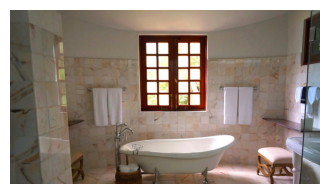

5120 2880
Tile(x_start=0, x_end=1024, y_start=0, y_end=1024, width=1024, height=1024)
Tile(x_start=819, x_end=1843, y_start=0, y_end=1024, width=1024, height=1024)
Tile(x_start=1638, x_end=2662, y_start=0, y_end=1024, width=1024, height=1024)
Tile(x_start=2457, x_end=3481, y_start=0, y_end=1024, width=1024, height=1024)
Tile(x_start=3276, x_end=4300, y_start=0, y_end=1024, width=1024, height=1024)
Tile(x_start=4095, x_end=5119, y_start=0, y_end=1024, width=1024, height=1024)
Tile(x_start=0, x_end=1024, y_start=618, y_end=1642, width=1024, height=1024)
Tile(x_start=819, x_end=1843, y_start=618, y_end=1642, width=1024, height=1024)
Tile(x_start=1638, x_end=2662, y_start=618, y_end=1642, width=1024, height=1024)
Tile(x_start=2457, x_end=3481, y_start=618, y_end=1642, width=1024, height=1024)
Tile(x_start=3276, x_end=4300, y_start=618, y_end=1642, width=1024, height=1024)
Tile(x_start=4095, x_end=5119, y_start=618, y_end=1642, width=1024, height=1024)
Tile(x_start=0, x_end=1024, y_start=12

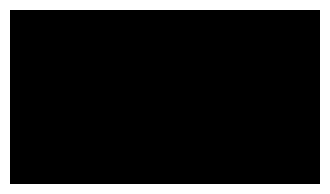

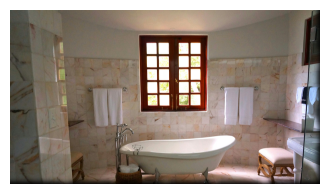

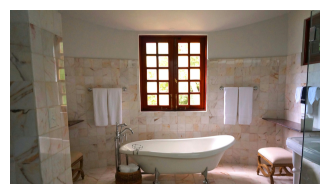

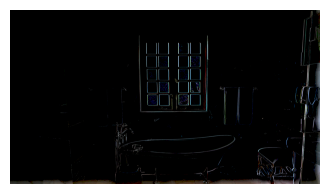

In [10]:
input_image = load_image(r"E:\AI\images\places\bathroom_1280_720.png")
plot_image(input_image, (4,4))
scale_factor = 4
image_upscaled_width = scale_factor * input_image.width
image_upscaled_height = scale_factor * input_image.height
print(image_upscaled_width, image_upscaled_height)

tile_upscaled_width=1024
tile_upscaled_height=1024
min_tile_scaled_overlap=128

tiles_upscaled = TileCreator.from_min_overlap(
    image_upscaled_width,
    image_upscaled_height,
    tile_upscaled_width,
    tile_upscaled_height,
    min_tile_scaled_overlap
)

for tile_upscaled in tiles_upscaled.tiles:
    print(tile_upscaled)

tile_width = math.ceil(tile_upscaled_width / scale_factor)
tile_height = math.ceil(tile_upscaled_height / scale_factor)
print(tile_width, tile_height)

tiles = TileCreator(input_image.width, 
                    input_image.height, 
                    tile_width, 
                    tile_height, 
                    tiles_upscaled.num_tiles_width, 
                    tiles_upscaled.num_tiles_height)

for tile in tiles.tiles:
    print(tile)

feather_radius = 40
upscaled_tiled_image = Image.new('RGBA', (image_upscaled_width, image_upscaled_height), color='black')
plot_image(upscaled_tiled_image, (4,4))


for index, (tile, tile_upscaled) in enumerate(zip(tiles.tiles, tiles_upscaled.tiles)):
    tile_image = tile.get_image_tile(input_image)
    tile_image_scaled = upscale_image(tile_image, scale_factor)
    upscaled_tiled_image = tile_upscaled.compose_with_mask(upscaled_tiled_image, tile_image_scaled, feather_radius)

    # plot_images_grid([tile_image, tile_image_scaled], n_cols=2, n_rows=1, figsize=(4, 2))

plot_image(upscaled_tiled_image,(4,4))
upscaled_image = upscale_image(input_image,scale_factor)
plot_image(upscaled_image,(4,4))
image_diff = image_diff_with_threshold(upscaled_tiled_image.convert('RGB'), upscaled_image.convert('RGB'))
plot_image(image_diff, (4,4))

In [48]:
for tile in tiles_upscaled.tiles:
    print(tile)
    tile_image = tile.get_image_tile(image_upscaled)
    tile_mask = tile.create_blending_mask_target_image_space(image_upscaled, 40)
    rgb_tile_mask = tile.visualize_blending_mask(tile_mask)
    plot_image(rgb_tile_mask, (8,5))
    plot_image(tile_image, (3,3))

Tile(x_start=0, x_end=1024, y_start=0, y_end=1024, width=1024, height=1024)


NameError: name 'image_upscaled' is not defined

In [6]:
import torch
from PIL import Image
import numpy as np
from RealESRGAN import RealESRGAN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = RealESRGAN(device, scale=4)
model.load_weights('weights/RealESRGAN_x4.pth', download=True)

input_image = load_image(r"E:\AI\images\places\bathroom_1280_720.png").convert('RGB')

sr_image = model.predict(input_image)

# sr_image.save('results/sr_image.png')

cuda


c:\Users\Admin\Documents\Code\airendering\stablediff_workflows\.venv\Lib\site-packages\RealESRGAN\model.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loadnet = torch.

In [8]:
sr_image.size

(5120, 2880)

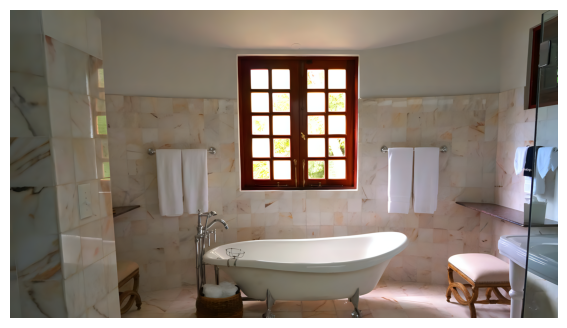

In [7]:
plot_image(sr_image, (8,4))

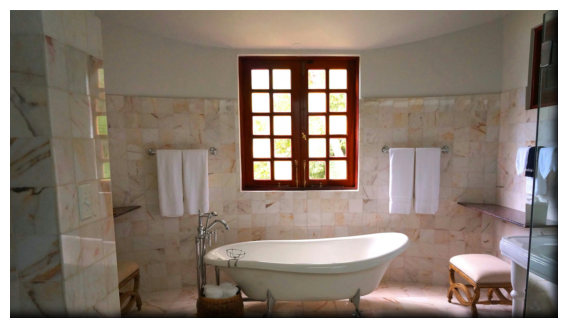

In [13]:
plot_image(upscaled_tiled_image, (8,4))

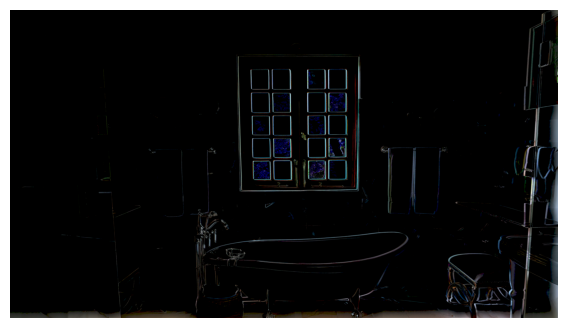

In [12]:
image_diff = image_diff_with_threshold(upscaled_tiled_image.convert('RGB'), sr_image.convert('RGB'))
plot_image(image_diff, (8,4))

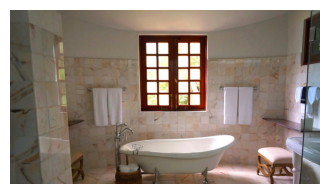

5120 2880
Tile(x_start=0, x_end=1024, y_start=0, y_end=1024, width=1024, height=1024)
Tile(x_start=819, x_end=1843, y_start=0, y_end=1024, width=1024, height=1024)
Tile(x_start=1638, x_end=2662, y_start=0, y_end=1024, width=1024, height=1024)
Tile(x_start=2457, x_end=3481, y_start=0, y_end=1024, width=1024, height=1024)
Tile(x_start=3276, x_end=4300, y_start=0, y_end=1024, width=1024, height=1024)
Tile(x_start=4095, x_end=5119, y_start=0, y_end=1024, width=1024, height=1024)
Tile(x_start=0, x_end=1024, y_start=618, y_end=1642, width=1024, height=1024)
Tile(x_start=819, x_end=1843, y_start=618, y_end=1642, width=1024, height=1024)
Tile(x_start=1638, x_end=2662, y_start=618, y_end=1642, width=1024, height=1024)
Tile(x_start=2457, x_end=3481, y_start=618, y_end=1642, width=1024, height=1024)
Tile(x_start=3276, x_end=4300, y_start=618, y_end=1642, width=1024, height=1024)
Tile(x_start=4095, x_end=5119, y_start=618, y_end=1642, width=1024, height=1024)
Tile(x_start=0, x_end=1024, y_start=12

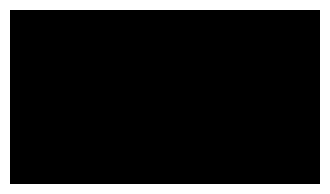

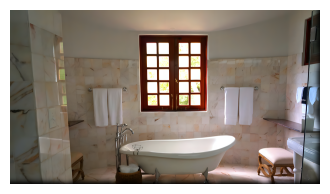

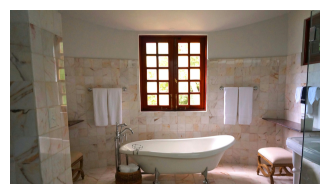

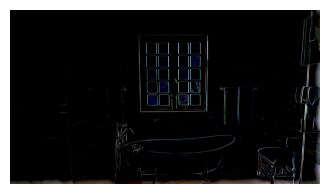

In [14]:
input_image = load_image(r"E:\AI\images\places\bathroom_1280_720.png")
plot_image(input_image, (4,4))
scale_factor = 4
image_upscaled_width = scale_factor * input_image.width
image_upscaled_height = scale_factor * input_image.height
print(image_upscaled_width, image_upscaled_height)

tile_upscaled_width=1024
tile_upscaled_height=1024
min_tile_scaled_overlap=128

tiles_upscaled = TileCreator.from_min_overlap(
    image_upscaled_width,
    image_upscaled_height,
    tile_upscaled_width,
    tile_upscaled_height,
    min_tile_scaled_overlap
)

for tile_upscaled in tiles_upscaled.tiles:
    print(tile_upscaled)

tile_width = math.ceil(tile_upscaled_width / scale_factor)
tile_height = math.ceil(tile_upscaled_height / scale_factor)
print(tile_width, tile_height)

tiles = TileCreator(input_image.width, 
                    input_image.height, 
                    tile_width, 
                    tile_height, 
                    tiles_upscaled.num_tiles_width, 
                    tiles_upscaled.num_tiles_height)

for tile in tiles.tiles:
    print(tile)

feather_radius = 40
upscaled_tiled_image = Image.new('RGB', (image_upscaled_width, image_upscaled_height), color='black')
plot_image(upscaled_tiled_image, (4,4))


for index, (tile, tile_upscaled) in enumerate(zip(tiles.tiles, tiles_upscaled.tiles)):
    tile_image = tile.get_image_tile(input_image)
    # tile_image_scaled = upscale_image(tile_image, scale_factor)
    tile_image_scaled = model.predict(tile_image.convert('RGB'))
    upscaled_tiled_image = tile_upscaled.compose_with_mask(upscaled_tiled_image, tile_image_scaled, feather_radius)

    # plot_images_grid([tile_image, tile_image_scaled], n_cols=2, n_rows=1, figsize=(4, 2))

plot_image(upscaled_tiled_image,(4,4))
upscaled_image = upscale_image(input_image,scale_factor)
plot_image(upscaled_image,(4,4))
image_diff = image_diff_with_threshold(upscaled_tiled_image.convert('RGB'), upscaled_image.convert('RGB'))
plot_image(image_diff, (4,4))

In [15]:
upscaled_tiled_image.save('4k_RealESRGAN_tiled.png')
sr_image.save('4k_RealESRGAN.png')
upscaled_image.save('4k_lazos.png')